In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tstools import TimeSeriesStationarizer


In [2]:
train_df = pd.read_csv('train_imputed.csv')
test_df = pd.read_csv('/Users/minqi/Documents/Kaggle/kaggle_hull_tactic_2025/train.csv')

### Simple linear regression

In [3]:
target = 'forward_returns'
non_dummy_features = [col for col in train_df.columns if col[0] in ['E','I','M','P','S','V']]
dummy_features = [col for col in train_df.columns if 'D' in col]
others = train_df.columns.difference(non_dummy_features + dummy_features + [target])

In [4]:
train_df_nondummy = train_df[non_dummy_features]
ts_stationarizer = TimeSeriesStationarizer(train_df_nondummy, window=12)
train_df_nondummy_stationary = ts_stationarizer.fit_transform()

train_df_stationary= pd.concat([train_df[others], train_df_nondummy_stationary, train_df[dummy_features], train_df[target]], axis=1)

Feature              | ADF p (orig) | Stationary? | ADF p (stn)  | Stationary?
--------------------------------------------------------------------------------
E1                   | 0.0000       | True       | 0.0000       | True
E10                  | 0.0437       | True       | 0.0437       | True
E11                  | 0.1264       | False      | 0.0000       | True
E12                  | 0.5235       | False      | 0.0000       | True
E13                  | 0.0000       | True       | 0.0000       | True
E14                  | 0.0000       | True       | 0.0000       | True
E15                  | 0.0672       | False      | 0.0000       | True
E16                  | 0.0001       | True       | 0.0001       | True
E17                  | 0.0077       | True       | 0.0077       | True
E18                  | 0.0002       | True       | 0.0002       | True
E19                  | 0.0000       | True       | 0.0000       | True
E2                   | 0.0581       | False      | 0.0000  

In [10]:
train_df_stationary.dropna(inplace=True)
train_df_stationary.to_csv('train_stationary.csv', index=False)

In [11]:
features = non_dummy_features + dummy_features
X = train_df_stationary[features]
y = train_df_stationary[target]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

In [12]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_val)

In [13]:
rmse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"RMSE: {rmse:.6f}")
print(f"R²: {r2:.4f}")

RMSE: 0.000101
R²: -0.2598


Negative R^2 error, meaning this baseline model performed worse than simply using the average

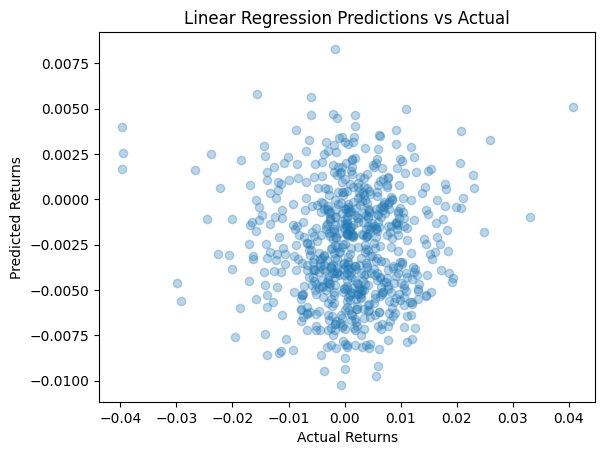

In [14]:

plt.scatter(y_val, y_pred, alpha=0.3)
plt.xlabel("Actual Returns")
plt.ylabel("Predicted Returns")
plt.title("Linear Regression Predictions vs Actual")
plt.show()

### Tree-based models

#### Random Forest

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
train_df = pd.read_csv('train_stationalized.csv')
features = [col for col in train_df.columns if col[0] in ['D','E','I','M','P','S','V']]
target = 'forward_returns'

X = train_df[features]
y = train_df[target]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)


In [7]:
model = RandomForestRegressor(
    n_estimators=200,
    max_depth=8,
    random_state=42,
    max_features=0.7
)
model.fit(X_train, y_train)

,n_estimators,200
,criterion,'squared_error'
,max_depth,8
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,0.7
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
y_pred = model.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
print(f"Random Forest RMSE: {mse:.6f}")

Random Forest RMSE: 0.000083


In [13]:
accuracy = np.mean(np.sign(y_pred) == np.sign(y_val))
print("Directional accuracy:", accuracy)

Directional accuracy: 0.5252976190476191


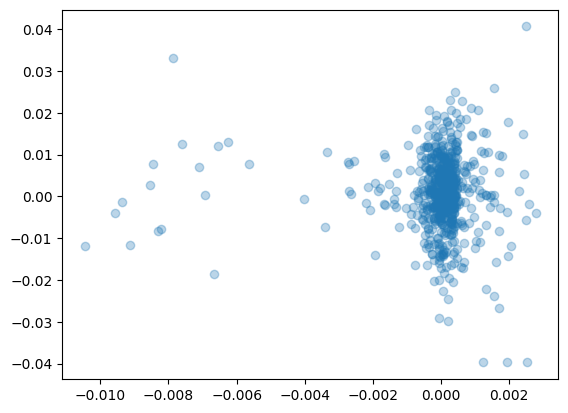

In [11]:
plt.plot(y_pred, y_val, 'o', alpha=0.3)

In [16]:
rho, pval = spearmanr(y_val, y_pred)
print(f"Spearman correlation (ρ): {rho:.4f}")
print(f"P-value: {pval:.4e}")

Spearman correlation (ρ): 0.0095
P-value: 8.0505e-01
